<a href="https://colab.research.google.com/github/andrsbtrg/S9_ML/blob/main/s9_part3_floorplans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data

Mount your Google drive to access files:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [2]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8 MB 41 kB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
     |████████████████████████████████| 3.8 MB 32.3 MB/s 
     |████████████████████████████████| 449 kB 27.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=bfb854473987083b2f584ac457afb46695912895622b69ebd0517b9657db3c91
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

Run to check tensorflow works

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

Importing libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Function to load images

In [6]:
def load_images(img_paths, target_size, interpolation='nearest', color_mode='rgb', normalize=False):
    images = []
    for img_path in img_paths:
        #load image
        img = keras.preprocessing.image.load_img(img_path, color_mode=color_mode, target_size=target_size, interpolation=interpolation)
        
        #convert to array
        img = keras.preprocessing.image.img_to_array(img)
        
        #normalize
        if normalize:
            img = img / 255
        
        #append
        images.append(img)
    
    images = np.stack(images, axis=0)
    
    return images

Loading the data:

Make sure that the path point to the specific folder "01_shapes_shuffled" inside the folder "dataset" in your drive



In [9]:
#=======================
#LOAD DATA
#=======================
#PATHS

# current path
current_folder = Path.cwd()

# dataset path
dataset_path = current_folder.joinpath("/content/drive/MyDrive/s9_dataset/03_floorplan_sketch")
# print(dataset_path)
# subfolders path
subfolders_path = dataset_path.glob("*")

# label list + subfolder list
label_str = []
subfolders = []

# label strings
for path in subfolders_path:
    subfolders.append(path)
    label_str.append(path.parts[-1])
# image paths + labels
labels = []
img_paths = []

for label_i, subfolder in enumerate(subfolders):
    for img_path in subfolder.glob("*.png"):
        img_paths.append(str(img_path))
        labels.append(label_i)

# convert labels and images to numpy array 
labels = np.stack(labels, axis = 0)

Loading the images and the labels:

In [11]:
# Load images
images = load_images(img_paths, target_size=(256,256), interpolation='bicubic', color_mode='grayscale', normalize=True)

#-----------------------
#SPLIT DATA
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=40)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(169, 256, 256, 1) (43, 256, 256, 1)
(169,) (43,)


**Image augmentation**

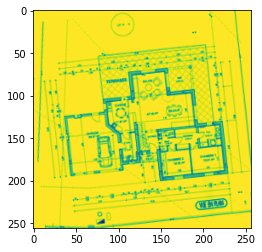

In [33]:
# Augmentation

# generator
img_datagenerator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'constant',
    cval = 1.0,
    validation_split = 0.15)
# batch size
batch_size_train = 1
batch_size_val = 1

# train generator, test generator
train_generator = img_datagenerator.flow(x_train, y_train, batch_size=batch_size_train, subset='training')
valid_generator = img_datagenerator.flow(x_train, y_train, batch_size=batch_size_train, subset='validation')

steps_per_epoch_train = train_generator.n // train_generator.batch_size
steps_per_epoch_valid = valid_generator.n // valid_generator.batch_size

# preview

img_rand = train_generator.next()[0][0]
plt.figure()
plt.imshow(tf.squeeze(img_rand))

# First Model

Architecture of the model:


In [ ]:
#=======================
#ARTIFICIAL NEURAL NETWORK
#=======================

ann_model = keras.Sequential([
                              # Input Layer
                              keras.layers.Flatten(input_shape = (28,28,1)),
                              # Hidden Layer
                              keras.layers.Dense(units=100, activation = 'relu'),
                              # Output Layer
                              keras.layers.Dense(units = 5, activation= 'softmax'),
])

# Second Model: Convolutional Neural Network

Architecture:

In [32]:
ann_model = None
ann_model = keras.Sequential([                              
                              # CONVOLUTIONAL NETWORK
                              ##    Convolution 01
                              keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu',input_shape = (256,256,1)),
                              keras.layers.MaxPool2D(pool_size=(2,2)),
                              ##    Convolution 02
                              keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation='relu'),
                              keras.layers.MaxPool2D(pool_size=(2,2)),
                              ##    Convolution 03
                              keras.layers.Conv2D(filters=256, kernel_size=(3,3),activation='relu'),
                              keras.layers.MaxPool2D(pool_size=(2,2)),

                              # FULLY CONNECTED NETWORK
                              # Input Layer
                              keras.layers.Flatten(),

                              # Hidden Layer
                              keras.layers.Dense(units=256, activation = 'relu'),
                              # Output Layer
                              keras.layers.Dense(units = 2, activation= 'softmax'),
])

# Traning and Evaluating

Set the Optimizer

In [35]:
ann_model.compile(optimizer = 'Adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'],
                  )
# Summary
ann_model.summary()
model_history = None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)           

**Training**

In [ ]:
model_history = ann_model.fit(train_generator, 
                                  validation_data=valid_generator,
                                  steps_per_epoch=steps_per_epoch_train,
                                  validation_steps=steps_per_epoch_valid,
                                  epochs=300)

Train for 144 steps, validate for 25 steps
Epoch 1/300
144/144 [==============================] - 8s 53ms/step - loss: 0.9838 - accuracy: 0.4861 - val_loss: 0.6869 - val_accuracy: 0.6800
Epoch 2/300
144/144 [==============================] - 7s 46ms/step - loss: 0.6916 - accuracy: 0.5764 - val_loss: 0.6802 - val_accuracy: 0.6800
Epoch 3/300
144/144 [==============================] - 7s 46ms/step - loss: 0.6848 - accuracy: 0.6042 - val_loss: 0.6731 - val_accuracy: 0.6800
Epoch 4/300
144/144 [==============================] - 7s 46ms/step - loss: 0.6445 - accuracy: 0.6389 - val_loss: 0.9448 - val_accuracy: 0.4400
Epoch 5/300
144/144 [==============================] - 7s 47ms/step - loss: 0.7927 - accuracy: 0.6250 - val_loss: 0.6202 - val_accuracy: 0.6800
Epoch 6/300
144/144 [==============================] - 7s 46ms/step - loss: 0.6762 - accuracy: 0.6250 - val_loss: 0.6434 - val_accuracy: 0.6800
Epoch 7/300
144/144 [==============================] - 7s 46ms/step - loss: 0.6236 - accuracy

Visualize epoch vs accuracy of the model

(0.0, 1.0)

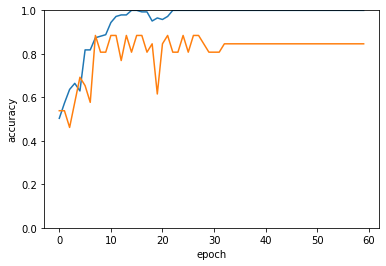

In [15]:
plt.figure()
plt.plot(model_history.history['accuracy'],label='accuracy')
plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim([0,1])

(0.0, 2.0)

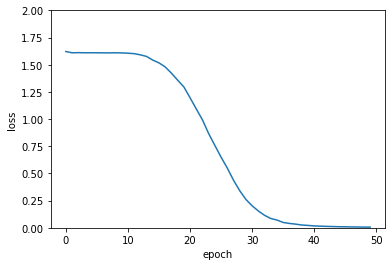

In [ ]:
plt.figure()
plt.plot(model_history.history['loss'],label='loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim([0,2])

---

Evaluate 



In [23]:
ann_model.evaluate(x_test,y_test)

43/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.5722060466921606, 0.8604651]

# Saving model

In [ ]:
ann_model.save('/content/drive/MyDrive/S9_Seminar_DeepLearning/saved_model/ann_model_01')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/S9_Seminar_DeepLearning/saved_model/ann_model_01/assets


# Loading model

In [ ]:
model_saved = keras.models.load_model('/content/drive/MyDrive/S9_Seminar_DeepLearning/saved_model/ann_model_01')
model_saved.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 79,005
Trainable params: 79,005
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_saved.evaluate(x_test,y_test)

56/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[3.8855698108673096, 0.26785713]

In [ ]:
img_zero = np.zeros(x_test[5].shape)
plt.figure()
plt.imshow(tf.squeeze(img_zero)) #using tf.squeeze on the image fixes the plt error

# Prediction

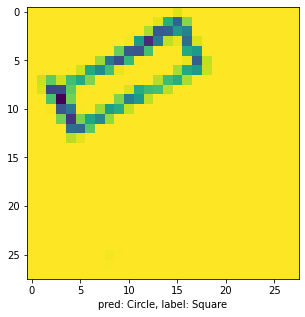

In [ ]:
def predict_image(x,y,img_index,model,label_list):
  # predict single image
  img = x[img_index]

  y_predict = model.predict(x[img_index:img_index+1])
  y_predict_class = np.argmax(y_predict)
  y_predict_class = label_list[y_predict_class]

  # real label
  y_real = y[img_index]
  y_real = label_list[y_real]

  # plot
  plt.figure(figsize=(5,5))
  plt.imshow(tf.squeeze(img)) #squeeze the image before displaying
  plt.xlabel("pred: {}, label: {}".format(y_predict_class,y_real))


labels_str = ['Square', 'Rectangle', 'Triangle', 'Pentagon', 'Circle']
predict_image(x_test,y_test,2,model_saved,labels_str)

**Confusion Matrix**

Text(42.0, 0.5, 'Ground truth')

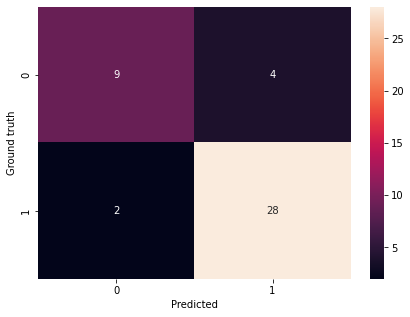

In [17]:
import seaborn as sb

y_pred = ann_model.predict(x_test)
y_pred_classes = [np.argmax(i) for i in y_pred]

confusion_matrix = tf.math.confusion_matrix(labels = y_test, predictions= y_pred_classes)

plt.figure(figsize=(7,5))
sb.heatmap(confusion_matrix, annot = True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Ground truth')